In [6]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

In [38]:
pf_data <- read_csv("final_data.csv") |>
#        mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
        select(-year, -max_portfolio_return_name) |>
        as_tibble()

head(pf_data)

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_value
<dbl>,<dbl>,<dbl>,<dbl>
2.337690,4.4,4.950000,22.37
1.552279,4.5,4.508333,18.26
2.188027,4.8,4.216667,20.79
3.376857,4.1,3.991667,4.77
2.826171,1.0,4.733333,3.38
1.586032,1.7,5.775000,4.77


In [58]:
pf_split <- initial_split(pf_data, prop = 0.75, strata = max_portfolio_return_value)
pf_training <- training(pf_split)
pf_testing <- testing(pf_split)

pf_testing

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_value
<dbl>,<dbl>,<dbl>,<dbl>
2.337690,4.4,4.950000,22.37
3.376857,4.1,3.991667,4.77
2.826171,1.0,4.733333,3.38
⋮,⋮,⋮,⋮
2.069337,2.3,8.066667,14.50
1.812210,2.3,3.666667,23.59
1.233584,-3.4,8.091666,15.74


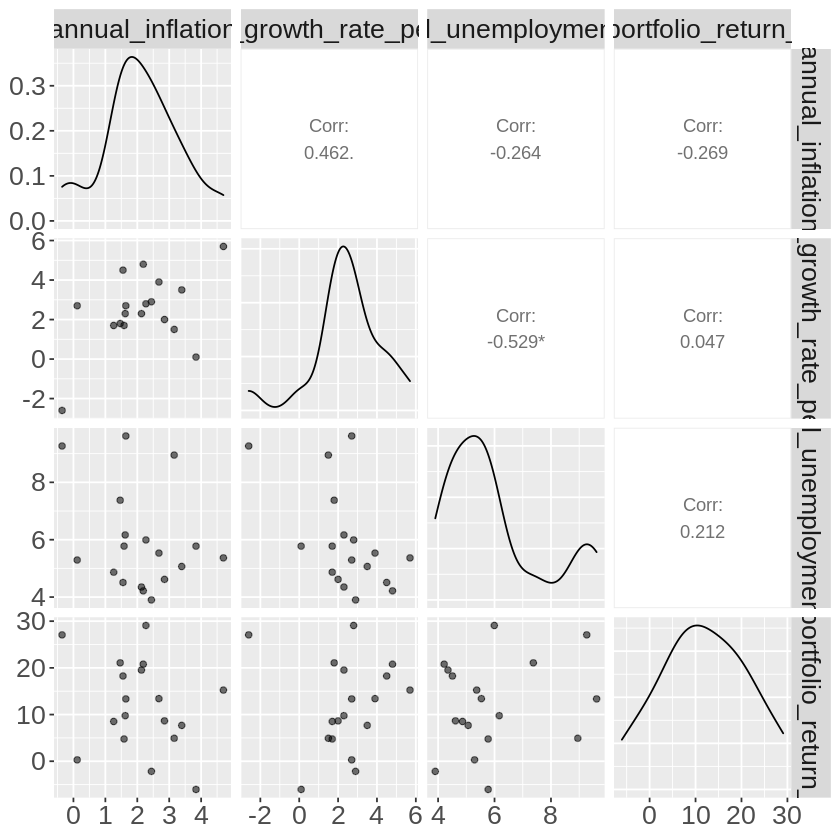

In [59]:
pf_eda <- ggpairs(pf_training, mapping = aes(alpha = 0.3))+
                theme(text = element_text(size = 20))

pf_eda

In [48]:
set.seed(9999)

# your code here
lm_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

pf_recipe <- recipe(max_portfolio_return_value ~ annual_inflation +
                        real_gdp_growth_rate_percentage +
                        annual_unemployment_rate, data = pf_training)

print(lm_spec)
print(credit_recipe)

Linear Regression Model Specification (regression)

Computational engine: lm 

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4


In [43]:
pf_fit <- workflow()|>
            add_recipe(pf_recipe)|>
            add_model(lm_spec)|>
            fit(pf_training)
pf_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                    (Intercept)                 annual_inflation  
                        17.8841                          -5.3947  
real_gdp_growth_rate_percentage         annual_unemployment_rate  
                         2.4526                           0.6167  


In [61]:
set.seed(9999)

lm_rmse <- pf_fit |>
         predict(pf_training) |>
         bind_cols(pf_training) |>
         metrics(truth = max_portfolio_return_value, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmse

lm_rmspe <- pf_fit |>
         predict(pf_testing) |>
         bind_cols(pf_testing) |>
         metrics(truth = max_portfolio_return_value, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()
lm_rmspe

[1] 9.976958

[1] 6.029756

In [76]:
set.seed(9999)

# your code here
knn_recipe <- recipe(max_portfolio_return_value ~., data=pf_training)|>
                step_center(all_predictors())|>
                step_scale(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("regression")

set_vfold <- vfold_cv(pf_training, v = 5, strata = max_portfolio_return_value)

knn_workflow <- workflow()|>
                add_recipe(knn_recipe)|>
                add_model(knn_spec)

gridvals <- tibble(neighbors=seq(1,18))

knn_results <- knn_workflow |>
                tune_grid(resample=set_vfold, grid=gridvals)|>
                collect_metrics()

kmin <- knn_results |>
        filter(.metric == "rmse")|>
        filter(mean == min(mean))|>
        pull(neighbors)

pf_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                set_engine("kknn")|>
                set_mode("regression")

pf_fit2 <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(credit_spec)|>
    fit(data = pf_training)

knn_rmspe <- credit_fit |>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate = .pred)|>
    filter(.metric == "rmse")|>
    pull(.estimate)

knn_rmspe

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 0 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
! Fold1: preprocessor 1/1, model 1/1: 18 samples were requested but there were 14 rows in the data. 9 will be ...

! Fold1: preprocessor 1/1, model 1/1 (predictions): data length [56] is not a sub-multiple or multiple of the number of colu...

x Fold1: preprocessor 1/1, model 1/1 (predictions): Error in cl[C]: only 0's may be mixed with negative subscripts

! Fold2: preprocessor 1/1, model 1/1: 18 samples were requested but there were 14 rows in the data. 9 will be ...

! Fold2: preprocessor 1/1, model 1/1 (predictions): data length [56] is not a sub-multiple or multiple of the number of colu...

x Fold2: preprocessor 1/1, model 1/1 (predictions): Error in cl[C]: only 0's may be mixed with negative subscripts

! Fold3: preprocessor 1/1, model 1/1: 18 samples

ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                    (Intercept)                 annual_inflation  
                          2.570                           -2.861  
real_gdp_growth_rate_percentage         annual_unemployment_rate  
                          2.021                            1.769  


[1] 6.029756

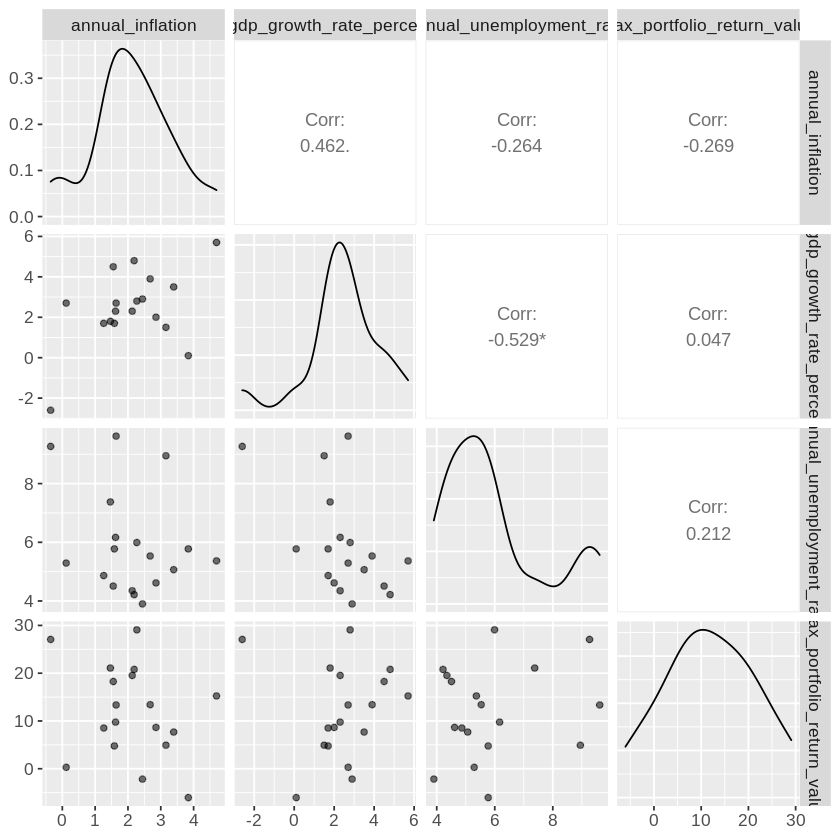

In [67]:
set.seed(2020)

pf_t_plot <- pf_training|>
    ggpairs(mapping=aes(alpha=0.05))+
    theme(text=element_text(size=13))
pf_t_plot

lm_specr <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

pf_reciper <- recipe(max_portfolio_return_value ~ ., data=pf_training)

pf_fitr <- workflow()|>
    add_recipe(pf_reciper)|>
    add_model(lm_specr)|>
    fit(data=pf_training)
pf_fitr

pf_rmsper <- pf_fit|>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate=.pred)|>
    filter(.metric=="rmse")|>
    select(.estimate)|>
    pull()
pf_rmsper